# SQuEC Solver, Illustrated

In this notebook we'll perform a SQueC solve, first in compact form (as it would be used in "production") and then broken down into steps.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from squec import (
    get_optimal_pairing,
    get_metagraph,
    Surface,
    VectorIJ,
    squec_solve,
    QubitType,
)

## Constructing the surface and the state query

First, we construct a Surface Code of the appropriate size, and flip the ancillae to the observed state. (In real use this would be observations from the QC; here we're just flipping a few examples.)

In [13]:
# Create a new Surface Code that is (in ij coordinates) 13×13.
s = Surface((15, 15))

# Flip four ancillae for this simple error condition:
s.flip_ancilla(VectorIJ(4, 4))
s.flip_ancilla(VectorIJ(2, 2))
s.flip_ancilla(VectorIJ(0, 4))
s.flip_ancilla(VectorIJ(6, 2))

## Performing the Solve

The solve is performed with the `squec_solve` function, which takes the surface code and the observed state as arguments. The function returns a list of the errors that were found, as `VectorIJ` objects.

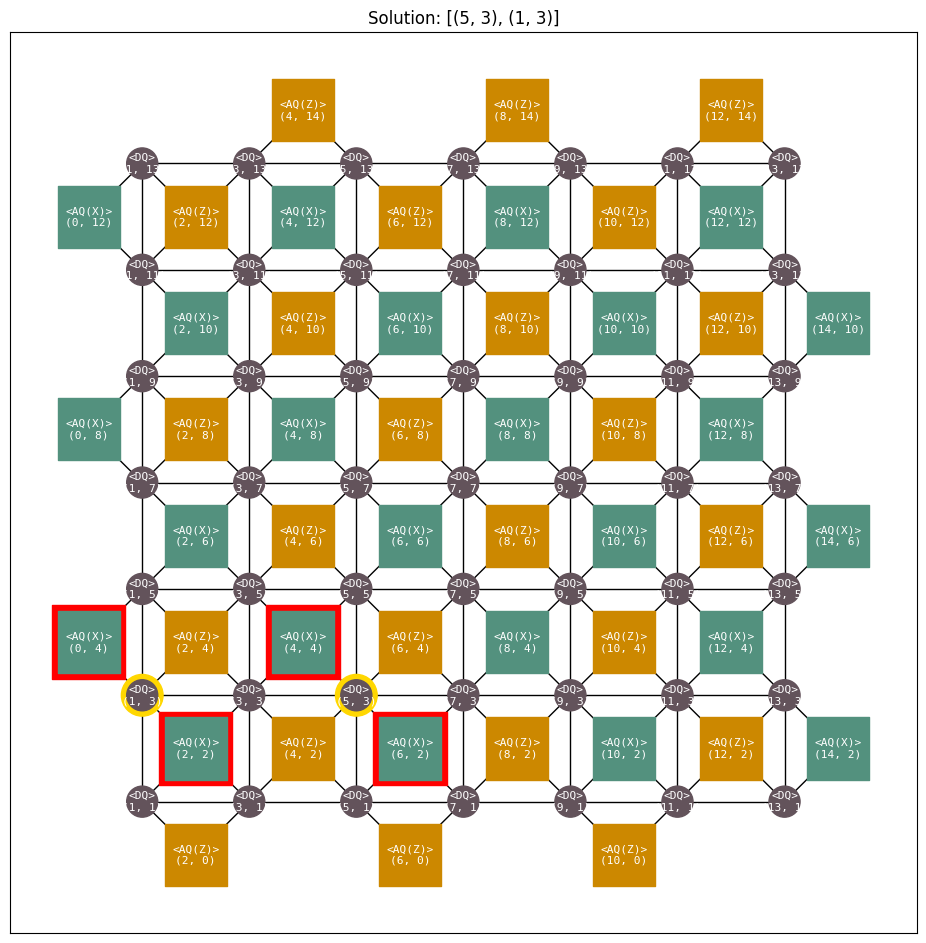

In [14]:
# Perform the solve:
solved_data_qubits = squec_solve(s)
# Highlight the vertices that were flipped by the solve (this is purely visual
# and just for illustration; this step is not necessary).
s.highlight_vertices(solved_data_qubits)

# Side-by-side pre and post-solve:
plt.figure(figsize=(13 * 0.9, 13 * 0.9))
plt.title(f"Solution: {solved_data_qubits}")
s.draw()

## Algorithm Breakdown

The SQueC implementation uses a few standard graph algorithms to perform the solve efficiently. In short, the algorithm looks for the set of cheapest paths that connect the ancillae to one another, or the cheapest set of edges that connect ancillae to the boundary.

To perform this, we'll run three steps:

* **Materialize a "meta-graph"** that represents ancillae as vertices, each with an accompanying "boundary" vertex. All ancillae are connected to one another with an edge, and each ancilla connects to its boundary vertex by a single edge. The weights of the edges correspond to how many data qubits need to be flipped to traverse that path.
* **Perform the optimal-pairing algorithm** to find the cheapest set of paths that connect the ancillae to one another, or the cheapest set of paths that connect an ancilla to the boundary.
* **Traverse the spanning set** to flip the necessary data qubits.

In [4]:
g = get_metagraph(s)

''

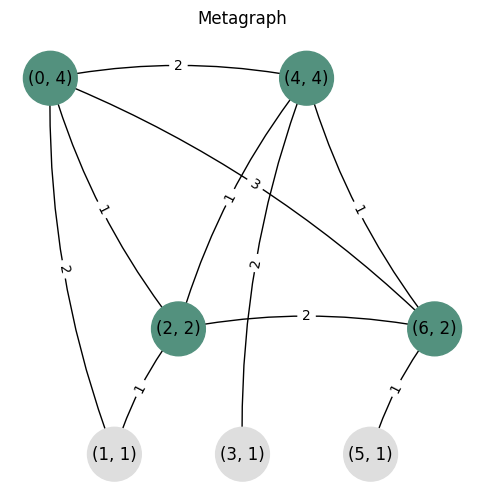

In [5]:
plt.figure(figsize=(6, 6))
plt.title("Metagraph")
nx.draw(
    g,
    with_labels=True,
    pos={n: (n.i, n.j) for n in g.nodes},
    connectionstyle="arc3,rad=0.1",
    node_color=[
        (
            "#53917E"
            if s.get_graph().nodes[n]["qubit_type"] == QubitType.ANCILLA
            else "#dedede"
        )
        for n in g.nodes
    ],
    node_size=1500,
    arrows=True,
)
nx.draw_networkx_edge_labels(
    g,
    pos={n: (n.i, n.j) for n in g.nodes},
    node_size=1500,
    edge_labels={(u, v): edata["dq_count"] for u, v, edata in g.edges(data=True)},
    connectionstyle="arc3,rad=0.1",
)
""



Now that we have a metagraph, we can perform the partial min-spanning set algorithm.

This algorithm is quite similar to the _Minimum-spanning-tree_ algorithm, except that instead of an exhaustive span of vertices in the graph, we can optionally exclude some vertices. This is implemented here in a _Partial Minimum Spanning Set_ algorithm, which to the best of my knowledge is not a well-studied algorithm, and this might be the first published implementation.

In [6]:
edges = get_optimal_pairing(s)
edges

[((4, 4), (6, 2)), ((0, 4), (2, 2))]

We now simply traverse the paths in the optimal edge set, flipping each data qubit we encounter. If we encounter an already-flipped data qubit, we flip it back.

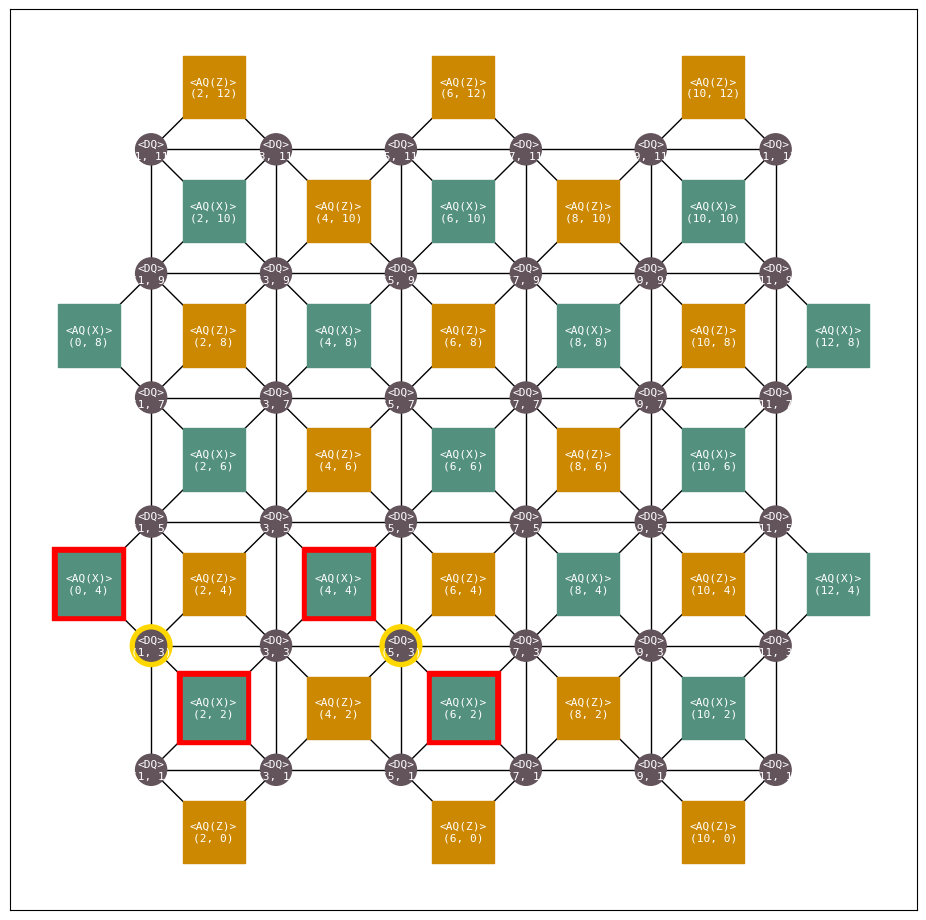

In [7]:
solve = squec_solve(s)
s.highlight_vertices(solve)

# Side-by-side pre and post-solve:
plt.figure(figsize=(13*0.9, 13*0.9))
s.draw()

## Additional Illustrated Examples

Let's solve a few more examples to illustrate some interesting conditions.

### Example 1: Single-Qubit Error

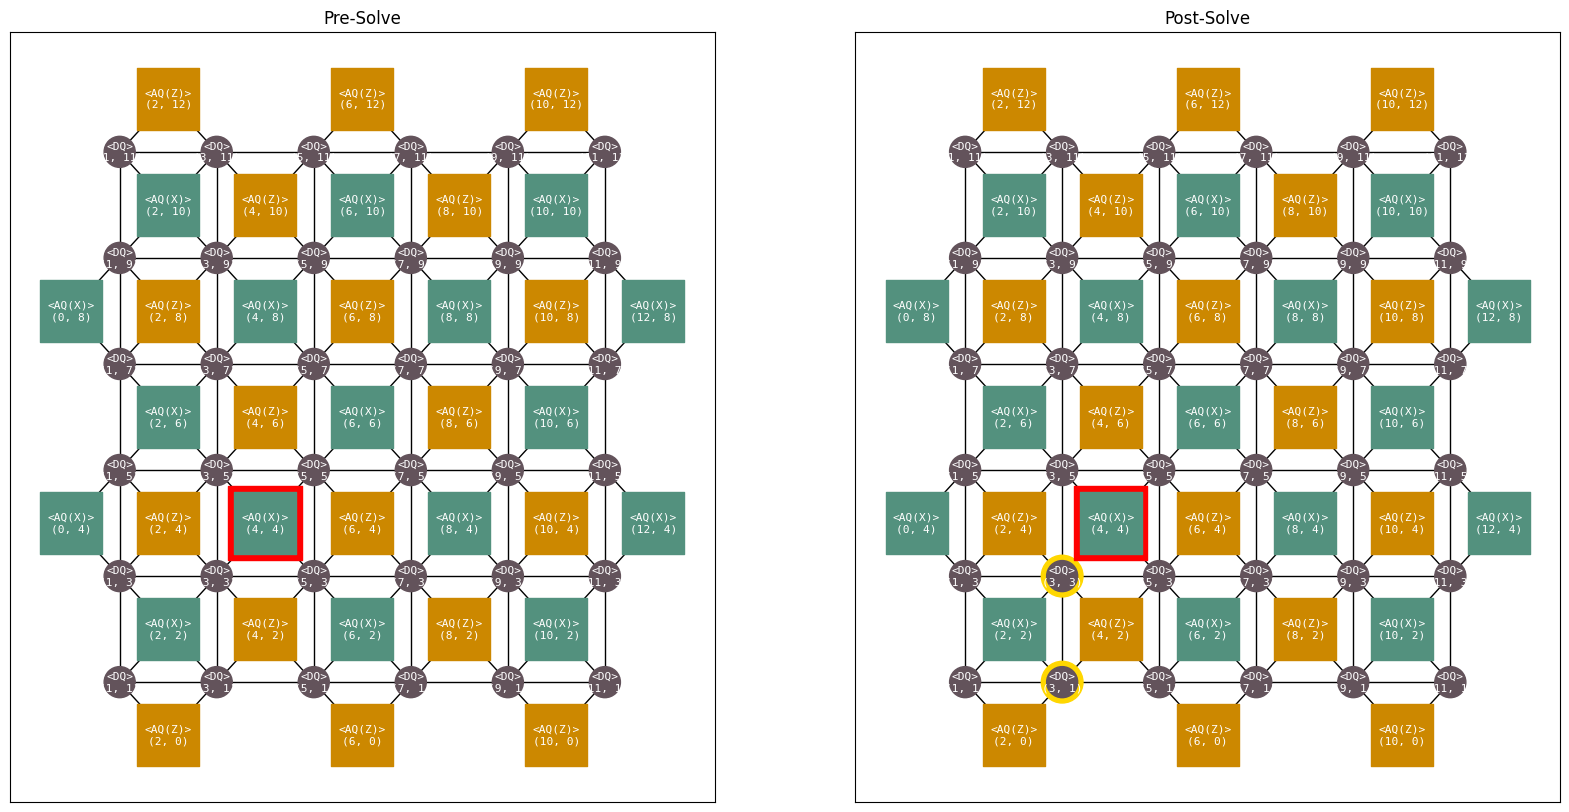

In [8]:
# Create a new Surface Code that is (in ij coordinates) 13×13.
s = Surface((13, 13))

# Flip one ancilla for this simple error condition:
s.flip_ancilla(VectorIJ(4, 4))

solve = squec_solve(s)

# Side-by-side pre and post-solve:
fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))

axs[0].set_title("Pre-Solve")
s.draw(draw_kwargs={"ax": axs[0]})
axs[1].set_title("Post-Solve")
s.highlight_vertices(solve)
s.draw(draw_kwargs={"ax": axs[1]})

### Example 2: Three-Qubit Error

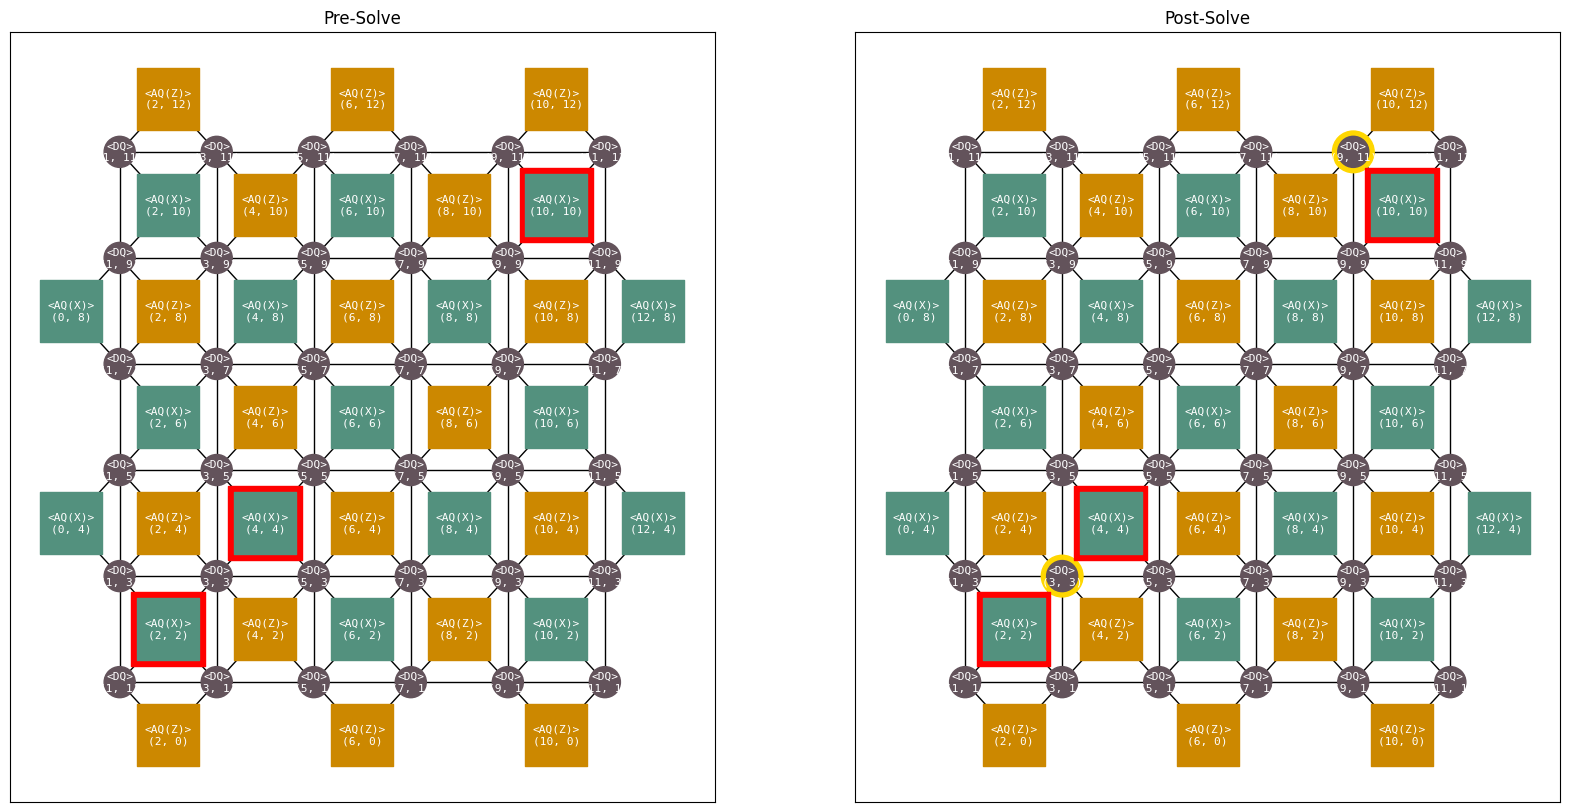

In [9]:
# Create a new Surface Code that is (in ij coordinates) 13×13.
s = Surface((13, 13))

# Flip three ancillae:
s.flip_ancilla(VectorIJ(4, 4))
s.flip_ancilla(VectorIJ(2, 2))
s.flip_ancilla(VectorIJ(10, 10))

solve = squec_solve(s)

# Side-by-side pre and post-solve:
fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))

axs[0].set_title("Pre-Solve")
s.draw(draw_kwargs={"ax": axs[0]})
axs[1].set_title("Post-Solve")
s.highlight_vertices(solve)
s.draw(draw_kwargs={"ax": axs[1]})

### Example 3: Two (Distant)-Qubit Error

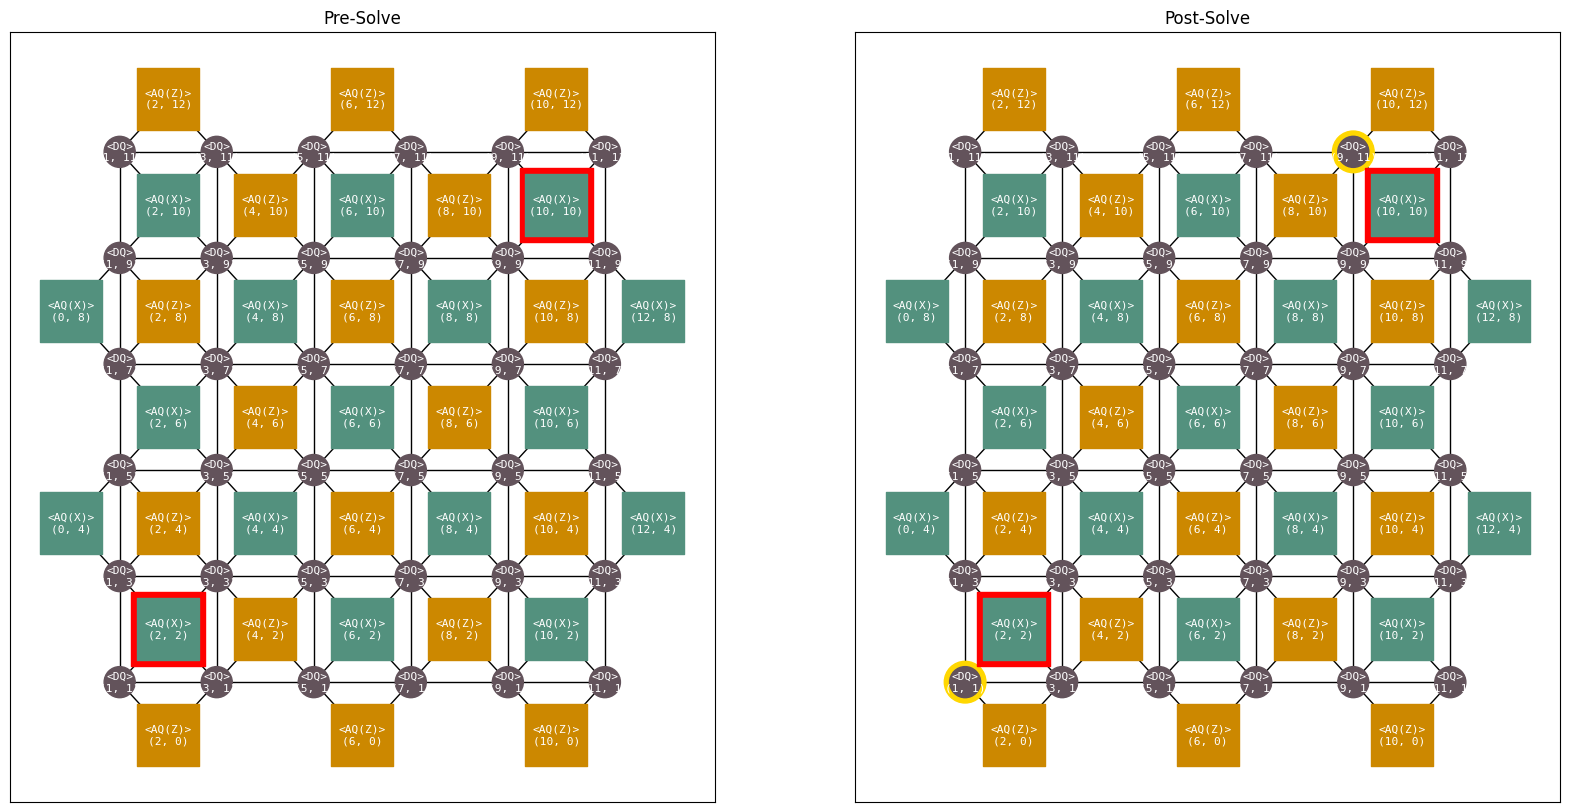

In [10]:
# Create a new Surface Code that is (in ij coordinates) 13×13.
s = Surface((13, 13))

# Flip two ancillae, but very far away:
s.flip_ancilla(VectorIJ(2, 2))
s.flip_ancilla(VectorIJ(10, 10))

solve = squec_solve(s)

# Side-by-side pre and post-solve:
fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))

axs[0].set_title("Pre-Solve")
s.draw(draw_kwargs={"ax": axs[0]})
axs[1].set_title("Post-Solve")
s.highlight_vertices(solve)
s.draw(draw_kwargs={"ax": axs[1]})